# Notas
- El score es 0 porque busca match perfecto. Usa todos los items, no solo los candidate ya que este set los tiene todos
- Para evaluar usando la web tenemos que devolver 100 items ordenador por session
- Clustering no he podido completar, si alguien lo tiene implementado puede añadirlo

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pickle
import pandas as pd
import numpy as np
import csv
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from utils import MultiHotEncoder
from sklearn.decomposition import TruncatedSVD


In [2]:
def load_model(pkl_filename):
    try:
        with open(pkl_filename, 'rb') as file:
            pickle_model = pickle.load(file)
        return pickle_model
    except FileNotFoundError as e:
        return
    except Exception as e:
        print(e)
        return
    
def save_model(model, pkl_filename):
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
    return 

# Read Data

# Selection
## Keep only sessions that purchased a candidate item

In [3]:
candidate_items = pd.read_csv('dressipi_recsys2022/candidate_items.csv', dtype=str)['item_id']

df_p = pd.read_csv('dressipi_recsys2022/train_purchases.csv', parse_dates=['date'], dtype={'item_id': str, 'session_id':int})
df_p = df_p[df_p['item_id'].isin(candidate_items)]
candidate_sessions = df_p['session_id']

df_s = pd.read_csv('dressipi_recsys2022/train_sessions.csv', parse_dates=['date'], dtype={'item_id': str, 'session_id':int})
print(df_s.shape, end=', ')
df_s = df_s[df_s['session_id'].isin(candidate_sessions)]
print(df_s.shape)


(4743820, 3), (2085385, 3)


In [4]:
items_viewed_by_session = df_s.groupby('session_id')['item_id'].unique()

In [5]:
assert (items_viewed_by_session.index == df_p['session_id']).all()

# KMeans

In [6]:
df_f = pd.read_csv('dressipi_recsys2022/item_features.csv', dtype='str')
features_by_item = df_f.groupby('item_id')['feature_category_id'].unique()

mlb_kmeans = MultiLabelBinarizer(sparse_output=False)
feature_by_item_mlb = mlb_kmeans.fit_transform(features_by_item)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


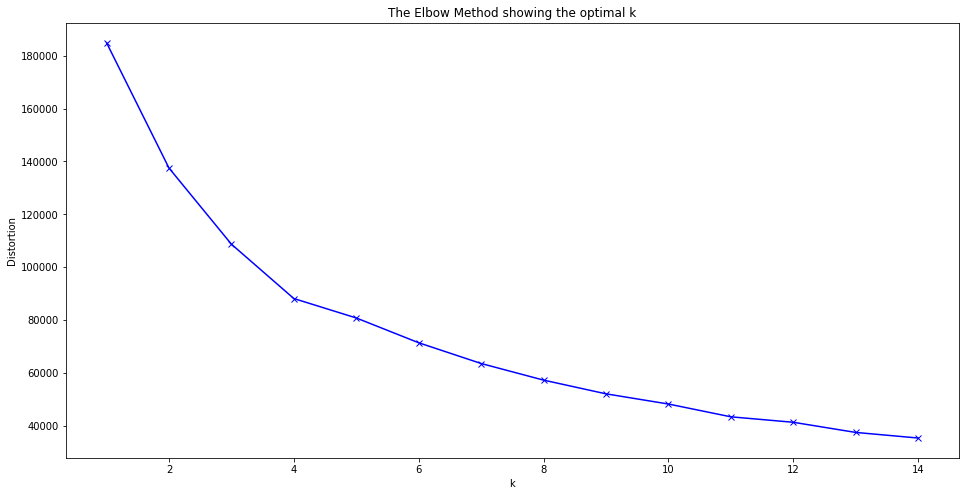

In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed 

kmeanmodels = dict()

K = range(1,15,1)

for k in K:
    print(k)
    kmeanmodels[k] = KMeans(n_clusters=k)
    kmeanmodels[k].fit(feature_by_item_mlb)

    distortions = [kmeanmodels[x].inertia_ for x in kmeanmodels]
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [8]:
# Select 4 clusters

In [9]:

n_clusters = 4
item_to_cluster = dict(zip(features_by_item.index, kmeanmodels[n_clusters].predict(feature_by_item_mlb)))

In [10]:
df_s['cluster'] = df_s['item_id'].map(item_to_cluster)
clusters_viewed_by_session = df_s.groupby('session_id')['cluster'].unique()

In [11]:
assert (clusters_viewed_by_session.index==df_p['session_id']).all()

In [12]:
last_seen = df_s.sort_values(['session_id', 'date'], ascending=[True, False]).drop_duplicates(subset='session_id').set_index('session_id')['item_id']
first_seen = df_s.sort_values(['session_id', 'date'], ascending=[True, True]).drop_duplicates(subset='session_id').set_index('session_id')['item_id']

In [13]:
all_data = df_p.set_index('session_id').copy()
all_data['items'] = items_viewed_by_session
all_data['clusters'] = clusters_viewed_by_session
all_data['last_seen'] = last_seen
all_data['first_seen'] = first_seen

# For memory porpoises, use only 10% of data for training

In [14]:
# train_size=0.1
train_size = 0.001
X_train, X_test, y_train, y_test = train_test_split(all_data, all_data['item_id'], random_state=42, train_size=train_size)
X_train.shape

(450, 6)

# Build Pipeline with transformations

In [15]:
# svd_components = 5000
svd_components = 50

column_transformer = ColumnTransformer([
    ('items_by_session', MultiHotEncoder(), ['items']), # ~18604
    ('clusters_by_session', MultiHotEncoder(), ['clusters']), # ~4
#     ('first_seen', OneHotEncoder(), ['first_seen']), # ~15449 
#     ('last_seen', OneHotEncoder(), ['last_seen']), # ~15139
    ])

pipeline = Pipeline([
     ('transform', column_transformer), 
     ('tsvd', TruncatedSVD(n_components=svd_components, random_state=42)), 
     ('random_forest', RandomForestClassifier(n_jobs=7, random_state=42))])

pipeline.fit(X_train, y_train)
save_model(pipeline, 'full.pkl')

In [26]:
print(sum(pipeline.named_steps['tsvd'].explained_variance_ratio_))

0.4918411934875262


In [16]:
model = load_model('full.pkl')

def capstone_score(model, x_test, y_real, n=100):
    _classes = model.classes_
    y_pred = _classes[np.flip(model.predict_proba(x_test).argsort())]
    scores = []
    for _y_true, _y_pred in zip(y_real, y_pred):
        index=np.where(_y_pred[:n] == _y_true)[0]
        if not index:
            pred_score = 0
        else:
            pred_score = 1-index[0]/n
        scores.append(pred_score)
    return np.mean(scores)
    
capstone_score(model, X_test, y_test)

/home/jano/miniconda3/envs/capstone/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:878: UserWarning: unknown class(es) ['10', '100', '10000', '10001', '10003', '10004', '10005', '10006', '10007', '10008', '10009', '10010', '10012', '10013', '10014', '10017', '10019', '10020', '10022', '10023', '10025', '10026', '10027', '10029', '1003', '10030', '10031', '10033', '10035', '10036', '10037', '10038', '10039', '1004', '10040', '10041', '10042', '10043', '10044', '10045', '10046', '10047', '10049', '1005', '10050', '10051', '10052', '10054', '10055', '10056', '1006', '10061', '10062', '10064', '10068', '1007', '10070', '10071', '10072', '10073', '10075', '10077', '10078', '10079', '1008', '10080', '10081', '10082', '10083', '10084', '10085', '10087', '1009', '10090', '10091', '10093', '10096', '10097', '10098', '101', '1010', '10100', '10101', '10108', '10109', '1011', '10110', '10111', '10113', '10115', '10117', '10119', '1012', '10120', '10122', '10123', '10124', '10125', '

0.04728805456045434